# Recurrent Neural Networks: Introduction

While CNNs work with filters or kernels that are applied in local patches of our data, RNNs work with sequences of data in which the order is important.
We have a sequence of elements (e.g., a time series or a sentence of words) and the goal of a RNN is to predict the next element(s) given the sequence, i.e., we want to forecast.

**Overview of the Notebook**
1. Some Notes on the Theory
2. Sine-Wave Prediction

## 1. Some Notes on the Theory

### (Very) Basic Theory

Examples of sequences: time series (e.g., sales), sentences, audio, car trajectories, music, etc.

Note that the **order or history is important; actually that's one of the tings is supposed to be understood/learnt.**
From that intuitive idea, we can derive how a recurrent neuron of a RNN is built: **previous outputs are fed back as inputs!**

Some properties:
- Recurrent neurons are also called *memory cells*
- RNNs are very flexible in terms of how outputs are converted into inputs
    - We can pass single vector of values
    - We can pass a sequence
    - We can pass entire layer outputs as inputs again to the same layer
- Typical architectures
    - **Sequence-to-sequence** (aka. *many to many*): we pass a sequence and exppect a sequence. For example, we could train a chatbot with Q-A sequences.
    - **Sequence-to-vector** (aka. *many to one*): we pass a sequence and expect an element. For example, we can use that architecture to generate text.
    - **Vector-to-sequence** (aka. *one to many*): for instance, given a word, predict the next 5.
- Major drawbacks of RNNs:
    1. The **vanishing gradient**, as in all other ANNs.
    2. We pass the previous output as input, so **we forget older elements**. It would be great to keep track of longer history, not only the short-term one. The **Long Short Term Memory Units (LSTMs)** address that.

### Exploding and Vanishing Gradients

Complex data usually requires more complex architectures that consist of more hidden layers.

When we train, we iteratively compute the derivative of the error (i.e., the difference between the expected and predicted output) with respect to the weights.
That error derivative is backpropagated to the neuron weights using the rule of chain and each weight is updated so that the error becomes smaller.
**Since we use the rule of chain for computing the derivative, we have chained multiplications of values; if the multiplied values are small, the resulting gradient becomes very small (it vanishes), and it becomes gigant if the values are big (it explodes).**
That is not desired, since we cannot accurately control how to change the weights: usually, too small insignificant changes are computed due to the vanishing gradient, especially closer to the input layers. Thus, basic patterns that should be detected in the first layers are not learnt!

The vanishing gradient is particularly string in RNNs.

Some points to take into account regarding the the **vanishing gradient**:
- The **sigmoid activation** makes the vanishing gradient worse: we squeeze/map the signals to the [0,1] region, but the slope (i.e., derivative) of the activation function is very small!
    - Better, use the ReLu (rectified linear unit): max(x,0).
    - Other options: leaky ReLu, ELU, etc.
- **Batch normalization** avoids also the vanishing gradient: batches of samples are normalized using the mean and the standard deviation of the batch.
- **Xavier initialization**: a method for choosing different initial weight values. Basically, initial values are set to belong to a uniform distribution scaled by `sqrt(6)/sqrt(in + out connections)`; it improves alleviates diminishing gradients.
- **Gradient clipping**: we clip a gradient when it reaches a given limit value; a drity trick that seems to work sometimes.
- **LSTM units** also reduce the phenomenon of the vanishing gradient, apart from bringing some advantages to reguar recursive neurons. However, exploding gradients can still occur.

### LSTM and GRU: Long Short Term Memory Units and Gated Recurrent Units

A simple recursive neuron takes its previous output $h(t-1)$ as additional input to the regular input $x(t)$.
The output $h(t)$ is usually computed by multiplying the weights to the concatenated inputs and applying the hyperbilic tangent as activation function:

$h(t) = \mathrm{tanh}(w\cdot[h(t-1)^{T},x(t)^{T}]^{T} + b)$

Recall that since the structures of RNNs are quite flexible, we could do that per neuron or per layer.

A **long short term memory** neuron is more sophisticated, as it consits of three entries and two exits:

- As recurrent outputs, we have short-term ($h$) and long-term ($c$) memory signals; their output value at time $t-1$ is also input at time $t$
- The short-term output $h$ is also the output that goes to the next neuron/layer
- Additionally we have the regular input $x$ coming from previous neurons/layers

Internally, several gates (paths) are distinguished (forget, input/update, output).
The general idea is that irrelevant signals are forgotten, while relevant data is preserved;
that is achieved by appliying sigmoid and tanh activations to the values and performing summations and mutiplications between them.

The following figure from the Wikipedia displays the internal operations:

![LSTM cell - source: Wikipedia](pics/LSTM_Cell.png)

Image Source: [Wikipedia article on LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)

There are several variations of that LSTM unit, such as
- **Peephole** units, which concatenate internal values
- **Gated Recurrent Units (GRUs)**, which combine forget an input gates to a single upddate gate, simplifying the unit

Although LSTMs are the default units used in RNNs, GRUs are getting more attention and are being deploying more and more lately.

![GRU cell - source: Wikipedia](pics/GRU_Cell.png)

Image Source: [Wikipedia article on GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit)

### Interesting Links

- [The Unreasonable Effectiveness of Recurrent Neural Networks, by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Exploring LSTMs, by Edwin Chen](http://blog.echen.me/2017/05/30/exploring-lstms/)
- [When to use GRU over LSTM? Stackexchange](https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)

### Practical Considerations with Time Series

- Time series on which we'd like to learn and predict need to have underlying patterns
- Enough data needs to be used to be fed to the network to learn all trends and seasonality components
    - We have a general trend component, lower frequency
    - We have also a seasonality component, higher frequency
- Thus, domain knowledge and experience is often necessary
- One possible approach is to work in batches of datapoints which are like windows in time and to predict one datapoint in the future for the given batch
    - Complete sequence: [0,1,2,3,4,5,6,7,8,9]
    - One possible batch: in [0,1,2,3], prediction [4]
    - Another batch: in [1,2,3,4], prediction [5]
    - If we want to predict more than one data point, we incorporate the prediction to our in batch removing the eldest datapoint
        - [6,7,8,9] -> [10]
        - [7,8,9,10] -> [11.1]
        - [8,9,10,11.1] -> [12.2]
        - ...
        - The further we go in time, the worse the prediction is expected to be!

## 2. Sine Wave Prediction

In [24]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### 2.1 Create/Load the Dataset

In [5]:
# First, we create our sine wave: y = sin(x)
x = np.linspace(0,50,501)

In [6]:
y = np.sin(x)

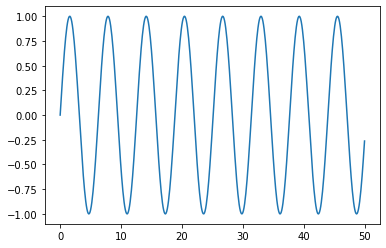

In [7]:
plt.plot(x,y)

In [10]:
# We conver our sine wave to be our dataset / dataframe
df = pd.DataFrame(data=y,index=x,columns=["Sine"])

In [25]:
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


### 2.2 Define the train/test split

In [12]:
len(df)

501

In [14]:
# We choose a percent of the dataset to be the test set
# That percent is taken from the end of the dataset
test_percent = 0.1

In [15]:
test_point = np.round(len(df)*test_percent)

In [16]:
test_point

50.0

In [17]:
test_ind = int(len(df)-test_point)

In [26]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### 2.3 Scale the Data

In [19]:
# Now, we need to scale our data
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit(train)

MinMaxScaler()

In [22]:
scaled_train = scaler.transform(train)

In [23]:
scaled_test = scaler.transform(test)

### 2.4 Define the Batches with a Generator

In [29]:
# We create batches using a very helpful class that provides a generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [48]:
# Utility class for generating batches of temporal data
#help(TimeseriesGenerator)

In [60]:
# Length of output sequences (in number of time steps)
# 2: we take 2 datapoints to predict the next
# Be aware: the length should be enough to learn ALL major trends + seasonality!
# Also: the larger the length, the longer the training time
length = 2
# Number of timeseries samples in each batch (1 performs well for timeseries)
batch_size = 1

In [61]:
# In our case, the data and the targets are the very same dataset
generator = TimeseriesGenerator(data=scaled_train,
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [62]:
# We explore what the generator does
len(scaled_train)

451

In [63]:
# The length of the generator will be
# len(data) - length
# because we can have that much subsets of sequences of the defined length
len(generator)

449

In [64]:
# We check the first element of the generator
X,y = generator[0]

In [65]:
X

array([[[0.49999912],
        [0.54991622]]])

In [66]:
y

array([[0.59933458]])